# Advanced mapmaking test with $h_n$ functions for 11 detectors

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from mapbased_syste.mapmaking import FrameworkSystematics
from mapbased_syste.io import read_detectors_h_n_maps

# Preparation of the inputs

First we can read the $h_n$ files

In [2]:
path_h_n_files = '/global/cfs/cdirs/sobs/sims/scan-s0001/h_n_maps/'

detector_features = [
    'w13_p000_f150_A',
    'w14_p082_f150_A',
    'w15_p164_f150_A',
    'w16_p246_f150_A',
    'w17_p328_f150_A',
    'w18_p410_f150_A',
    'w20_p062_f150_A',
    'w21_p144_f150_A',
    'w22_p226_f150_A',
    'w23_p308_f150_A',
    'w24_p390_f150_A'
]

h_n_names = [path_h_n_files + 'high_cadence_constant_scan_1_el_' + det_features for det_features in detector_features]

In [3]:
%%time
h_n_spin_dict = read_detectors_h_n_maps(h_n_names, list_spin=[2,4])

CPU times: user 20 s, sys: 48.3 s, total: 1min 8s
Wall time: 1min 9s


In [5]:
n_det = h_n_spin_dict[0].shape[0]

Build a mask from the $h_n$ files

/global/homes/m/mag/.conda/envs/beams_env/lib/python3.10/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


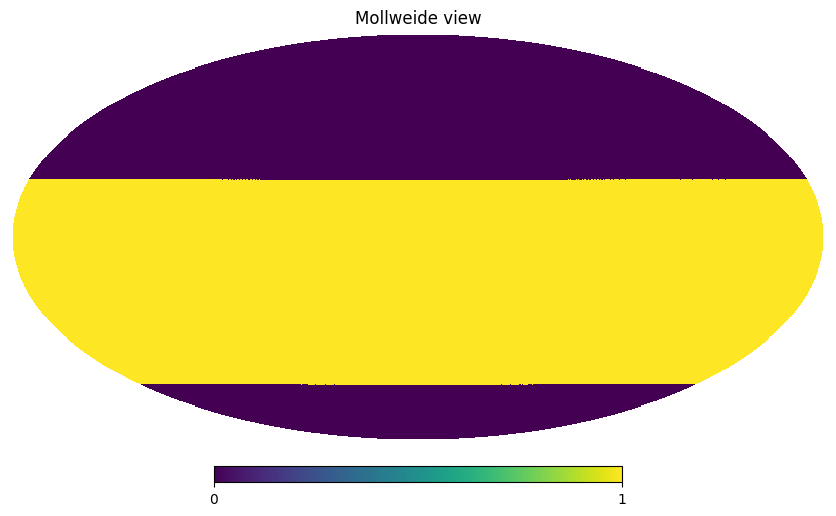

In [6]:
mask = np.zeros_like(h_n_spin_dict[2][0,...])
mask[h_n_spin_dict[2][0,...] != 0] = 1

hp.mollview(mask)

Then create the `FrameworkSystematics` object

In [7]:
nside = hp.npix2nside(h_n_spin_dict[2][0,...].size)

syste_object = FrameworkSystematics(nside=nside, nstokes=2, lmax=2*nside, list_spin_output=[-2,2])

Prepare the input sky maps

In [8]:
%%time
spin_sky_maps = syste_object.get_spin_sky_maps()

spin_sky_maps = {spin:spin_sky_maps[spin]*mask for spin in spin_sky_maps.keys()}

Calculating spectra from CAMB !
CPU times: user 28min 49s, sys: 15.4 s, total: 29min 4s
Wall time: 29.1 s


Plotting the real and imaginary part of the spin $2$, $-2$ maps

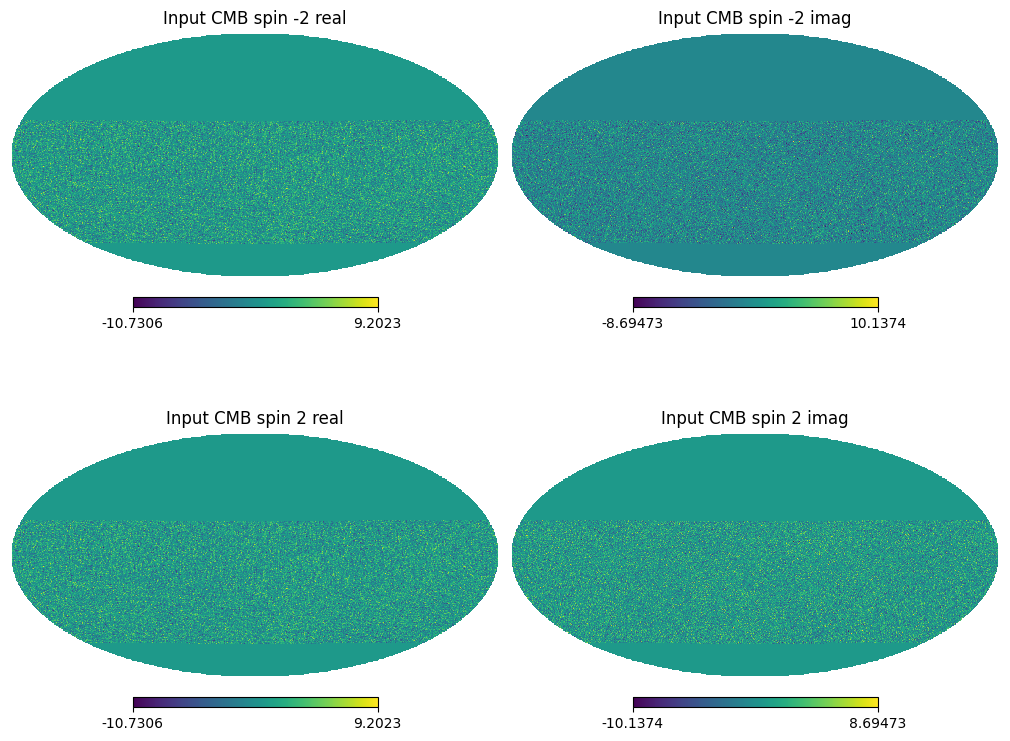

In [9]:
plt.figure(figsize=(10,8))
hp.mollview(spin_sky_maps[-2].real, sub=(2,2,1), title='Input CMB spin -2 real') #, min=-5, max=5
hp.mollview(spin_sky_maps[-2].imag, sub=(2,2,2), title='Input CMB spin -2 imag')
hp.mollview(spin_sky_maps[2].real, sub=(2,2,3), title='Input CMB spin 2 real')
hp.mollview(spin_sky_maps[2].imag, sub=(2,2,4), title='Input CMB spin 2 imag')

Checking the $Q$ and $U$ Stokes parameters of those spin maps

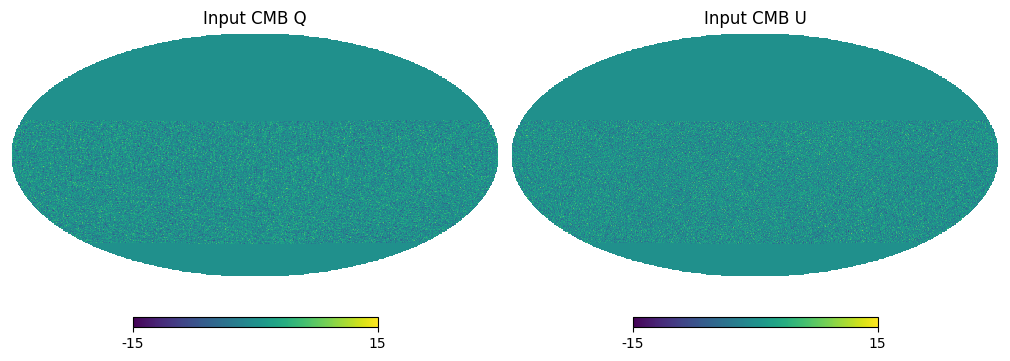

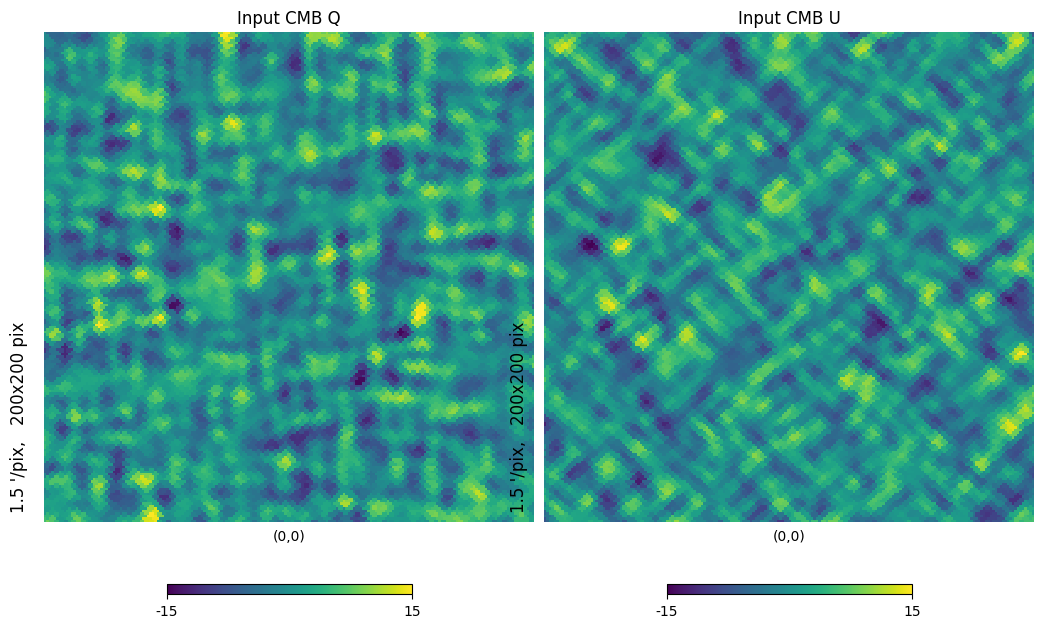

In [10]:
value = 15
plt.figure(figsize=(10,8))
hp.mollview((spin_sky_maps[2].real + spin_sky_maps[-2].real)/2, sub=(1,2,1), title='Input CMB Q', min=-value, max=value)
hp.mollview((spin_sky_maps[2].imag - spin_sky_maps[-2].imag)/2, sub=(1,2,2), title='Input CMB U', min=-value, max=value)

plt.figure(figsize=(10,8))
hp.gnomview(spin_sky_maps[2].real + spin_sky_maps[-2].real, sub=(1,2,1), title='Input CMB Q', min=-value, max=value)
hp.gnomview(spin_sky_maps[2].imag - spin_sky_maps[-2].imag, sub=(1,2,2), title='Input CMB U', min=-value, max=value)
plt.show()


For this basic mapmaking, we do not include systematics

In [11]:
spin_systematics_maps = {spin: np.zeros((n_det,)+ spin_sky_maps[spin].shape) for spin in spin_sky_maps.keys()} 
# The systematics must have the structure {spin: array[ndet, npix]}
# In this case we are simulating only one detector

## Mapmaking

We can finally perform mapmaking

In [12]:
%%time
final_maps, inverse_mapmaking_matrix = syste_object.compute_total_maps(mask, h_n_spin_dict, spin_sky_maps, spin_systematics_maps, return_inverse_mapmaking_matrix=True)

CPU times: user 23.9 s, sys: 10.3 s, total: 34.2 s
Wall time: 34.5 s


And form from the obtained maps the final $Q$ and $U$ maps

In [13]:
final_Q_map = (final_maps[-2,:] + final_maps[-1,:])/2.
final_U_map = 1j*(final_maps[-2,:] - final_maps[-1,:])/2.

We can plot them, both the real and imaginary parts for sanity tests

In [14]:
extended_final_maps = np.zeros((2,12*nside**2), dtype=complex)
extended_final_maps[0, mask != 0] = final_Q_map.real
extended_final_maps[1, mask != 0] = final_U_map.real

extended_final_maps_imag = np.zeros((2,12*nside**2), dtype=complex)
extended_final_maps_imag[0, mask != 0] = final_Q_map.imag
extended_final_maps_imag[1, mask != 0] = final_U_map.imag

/global/homes/m/mag/.conda/envs/beams_env/lib/python3.10/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


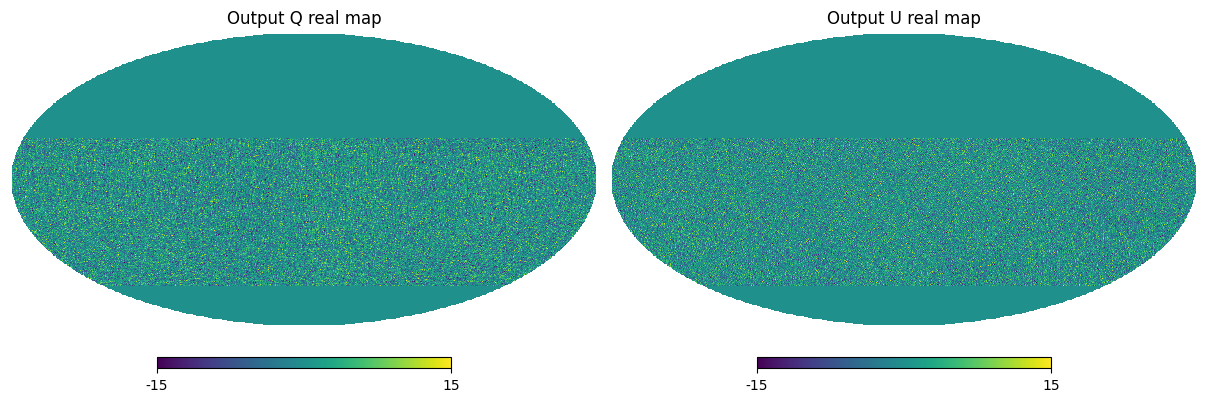

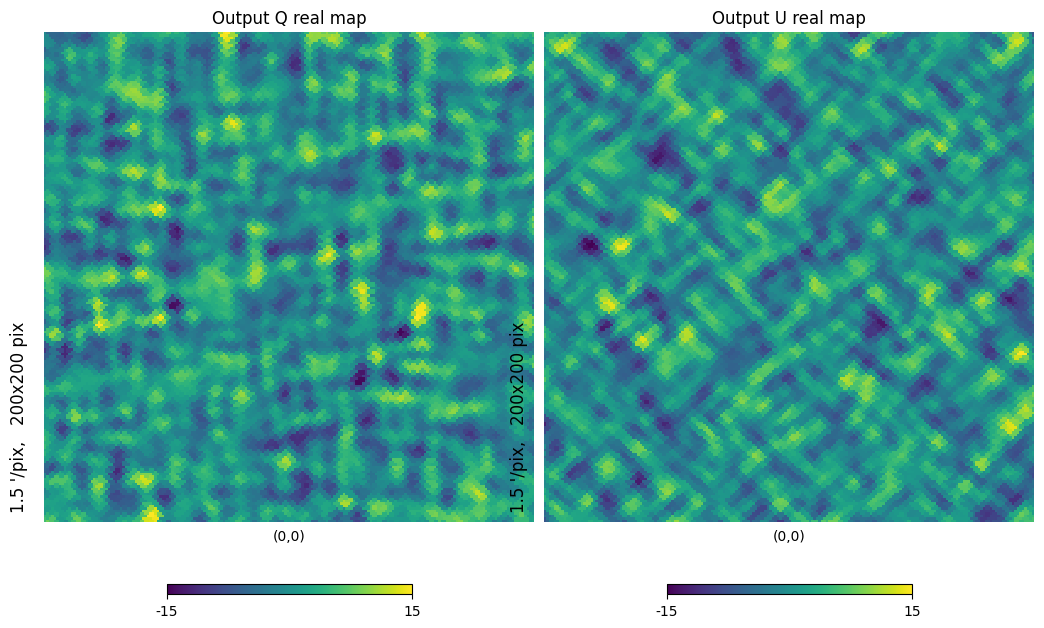

In [15]:
value = 15
plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps[0], sub=(1,2,1), title='Output Q real map', min=-value, max=value)
hp.mollview(extended_final_maps[1], sub=(1,2,2), title='Output U real map', min=-value, max=value)

plt.figure(figsize=(10,8))
hp.gnomview(extended_final_maps[0], sub=(1,2,1), title='Output Q real map', min=-value, max=value)
hp.gnomview(extended_final_maps[1], sub=(1,2,2), title='Output U real map', min=-value, max=value)


Note that the imaginary maps are supposed to be $0$

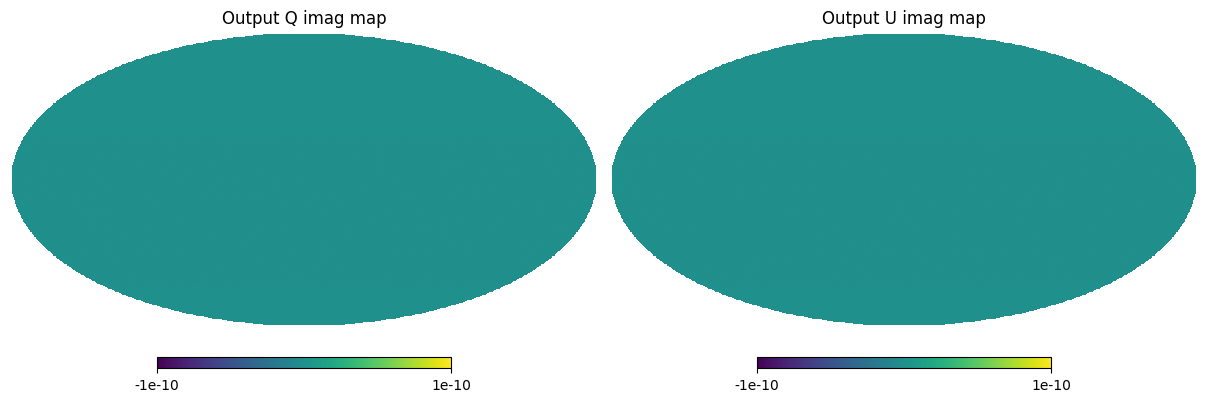

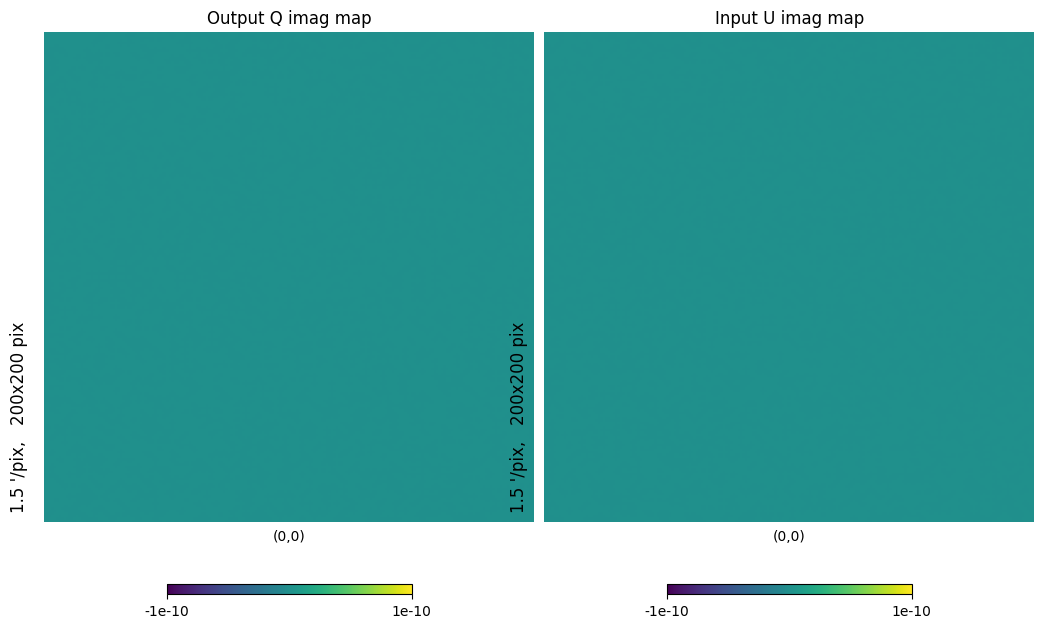

In [16]:
value = 1e-10
plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps_imag[0], sub=(1,2,1), title='Output Q imag map', min=-value, max=value)
hp.mollview(extended_final_maps_imag[1], sub=(1,2,2), title='Output U imag map', min=-value, max=value)
plt.show()


plt.figure(figsize=(10,8))
hp.gnomview(extended_final_maps_imag[0], sub=(1,2,1), title='Output Q imag map', min=-value, max=value)
hp.gnomview(extended_final_maps_imag[1], sub=(1,2,2), title='Input U imag map', min=-value, max=value)
plt.show()


Checking how many pixels with imaginary output are actually in the output maps, and how they contribute to the final output.

In [17]:
abs_values = np.abs(extended_final_maps_imag)
pixels_to_hist = abs_values[abs_values > 1e-10]


In [18]:
pixels_to_hist.size // 2 / final_U_map.size

0.0

/tmp/ipykernel_671483/2793825970.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


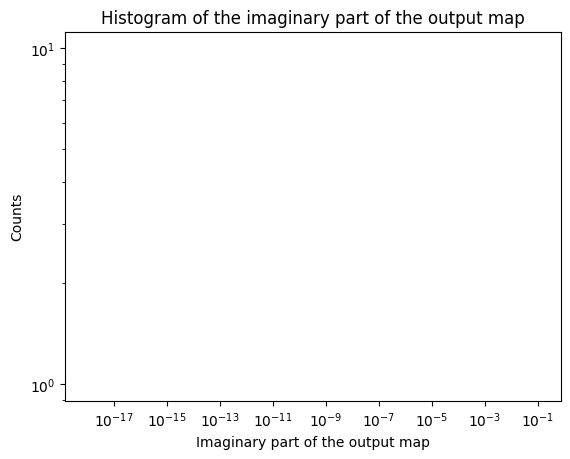

In [19]:

plt.hist(pixels_to_hist, bins=np.logspace(-18, -1, 200))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Imaginary part of the output map')
plt.ylabel('Counts')
plt.title('Histogram of the imaginary part of the output map')
plt.show()

## Mapmaking matrix and condition number

We can plot the output inverse mapmaking matrix $M^{-1}$ to understand if the mapmaking was properly done (beware `inverse_mapmaking_matrix` is ordered as `[npix, nstokes, nstokes]`)

In [20]:
extended_inverse_mapmaking_matrix = np.zeros((2,2,12*nside**2), dtype=complex)
extended_inverse_mapmaking_matrix[:,:, mask != 0] = inverse_mapmaking_matrix.T

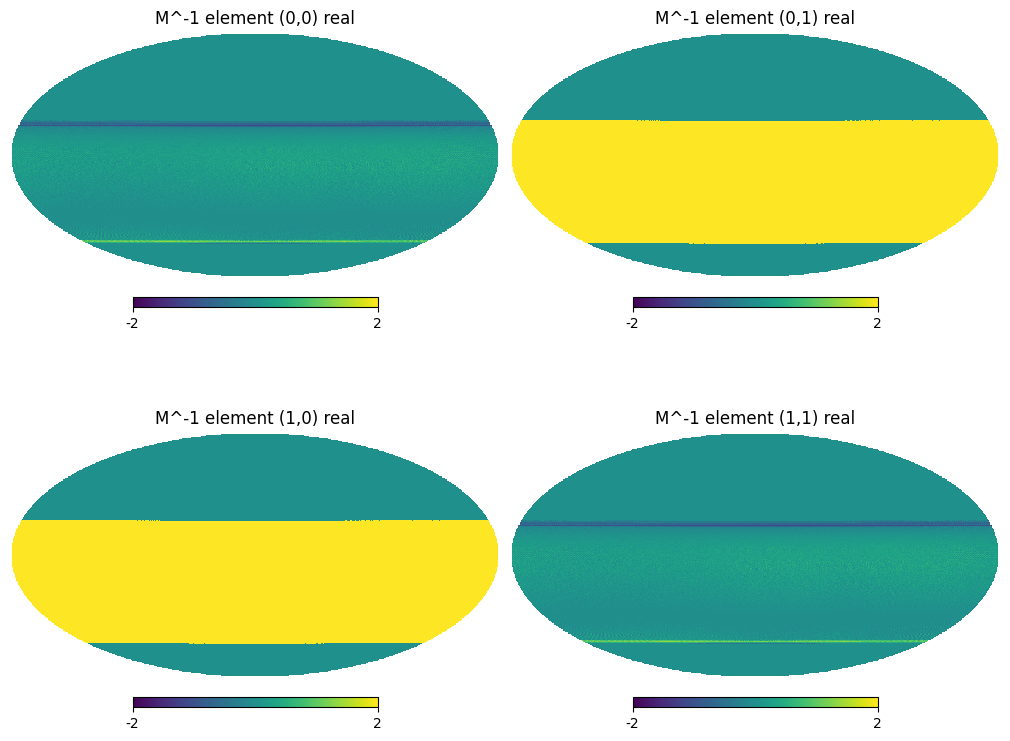

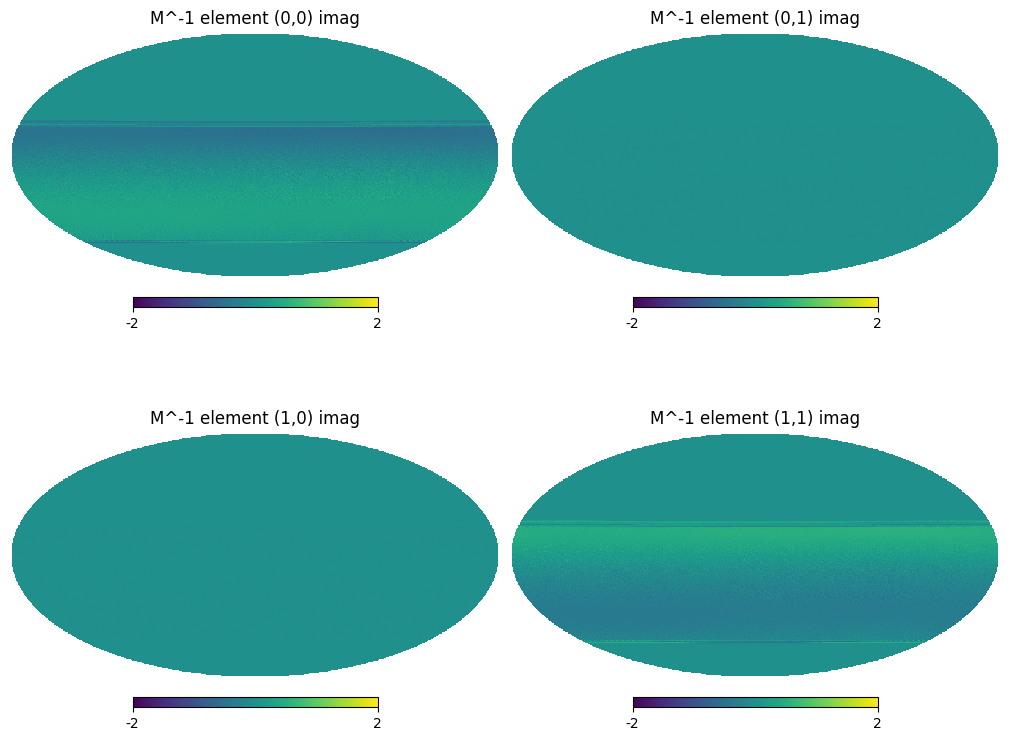

In [21]:
value = 2
plt.figure(figsize=(10,8))
for i in range(4):
    row_ = i//2
    col_ = i%2
    
    hp.mollview(extended_inverse_mapmaking_matrix[row_,col_,:].real, sub=(2,2,i+1), title=f'M^-1 element ({row_},{col_}) real', min=-value, max=value)

plt.figure(figsize=(10,8))
for i in range(4):
    row_ = i//2
    col_ = i%2
    hp.mollview(extended_inverse_mapmaking_matrix[row_,col_,:].imag, sub=(2,2,i+1), title=f'M^-1 element ({row_},{col_}) imag', min=-value, max=value)
plt.show()

We can retrieve the original mapmaking matrix which was inversed and do the same

In [22]:
mapmaking_matrix = np.linalg.pinv(inverse_mapmaking_matrix)

In [23]:
extended_mapmaking_matrix = np.zeros((2,2,12*nside**2), dtype=complex)
extended_mapmaking_matrix[:,:, mask != 0] = mapmaking_matrix.T

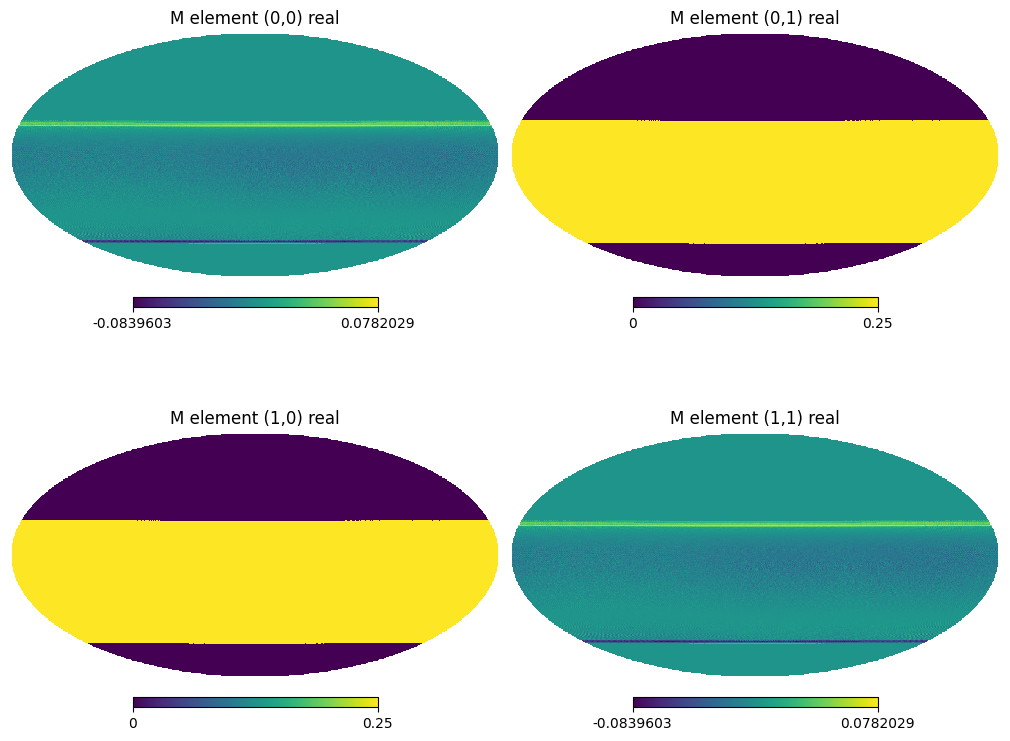

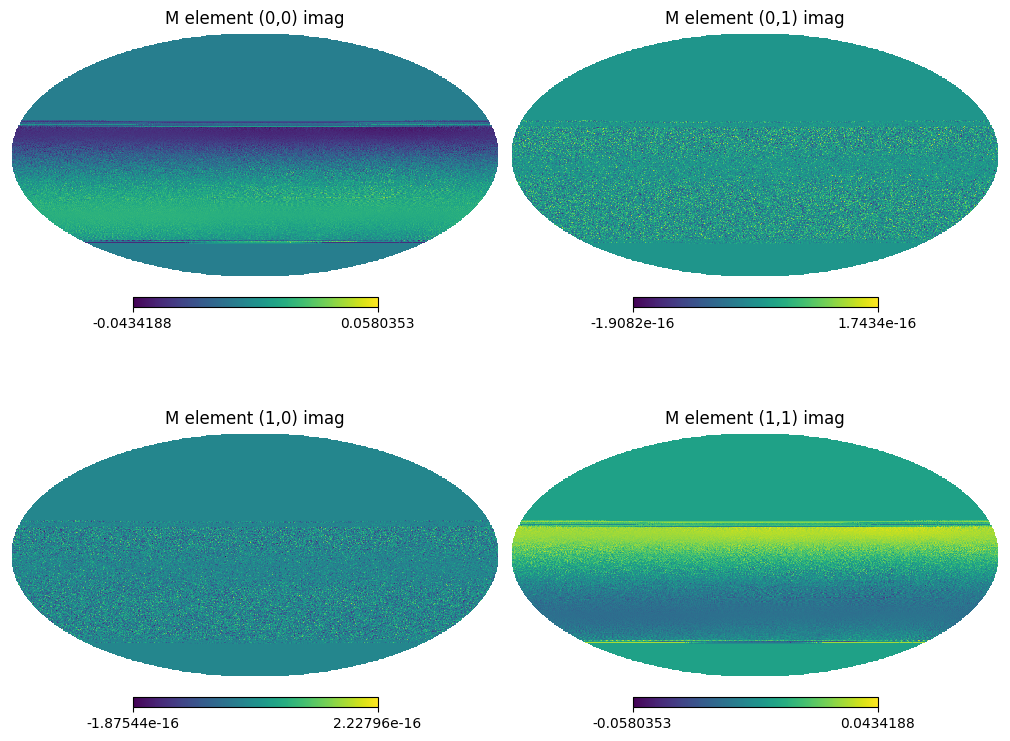

In [24]:
value = 10
plt.figure(figsize=(10,8))
for i in range(4):
    row_ = i//2
    col_ = i%2
    
    hp.mollview(extended_mapmaking_matrix[row_,col_,:].real, sub=(2,2,i+1), title=f'M element ({row_},{col_}) real')#, min=-value, max=value)

plt.figure(figsize=(10,8))
for i in range(4):
    row_ = i//2
    col_ = i%2
    
    hp.mollview(extended_mapmaking_matrix[row_,col_,:].imag, sub=(2,2,i+1), title=f'M element ({row_},{col_}) imag')#, min=-value, max=value)

### Condition number

We can compute the condition number of the mapmaking matrix, to see which pixels were likely not well inverted. 

Note that the inversion is always done using `np.linalg.pinv`

In [25]:
conditioned_number = np.linalg.cond(mapmaking_matrix)

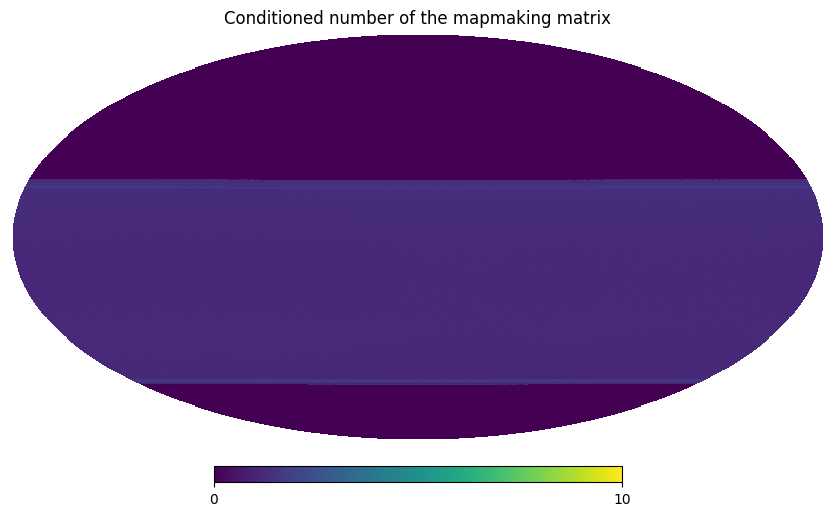

In [26]:
conditioned_number_extended = np.zeros(12*nside**2)
conditioned_number_extended[mask != 0] = conditioned_number

hp.mollview(conditioned_number_extended, title='Conditioned number of the mapmaking matrix', max=10)

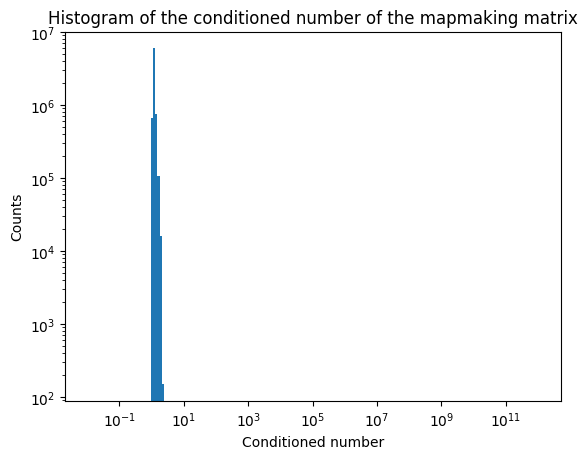

In [27]:
plt.hist(conditioned_number, bins=np.logspace(-2, 12, 200))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Conditioned number')
plt.ylabel('Counts')
plt.title('Histogram of the conditioned number of the mapmaking matrix')
plt.show()

Then we can focus on only the best reconstructed pixels, with conditioned number $<10$

In [28]:
best_pixels = conditioned_number_extended < 10


extended_final_maps_best_pixels = np.copy(extended_final_maps)
extended_final_maps_imag_best_pixels = np.copy(extended_final_maps_imag)

extended_final_maps_best_pixels[extended_final_maps_best_pixels == 0] = hp.UNSEEN
extended_final_maps_imag_best_pixels[extended_final_maps_imag_best_pixels == 0] = hp.UNSEEN

extended_final_maps_best_pixels[:,~best_pixels] = hp.UNSEEN
extended_final_maps_imag_best_pixels[:,~best_pixels] = hp.UNSEEN

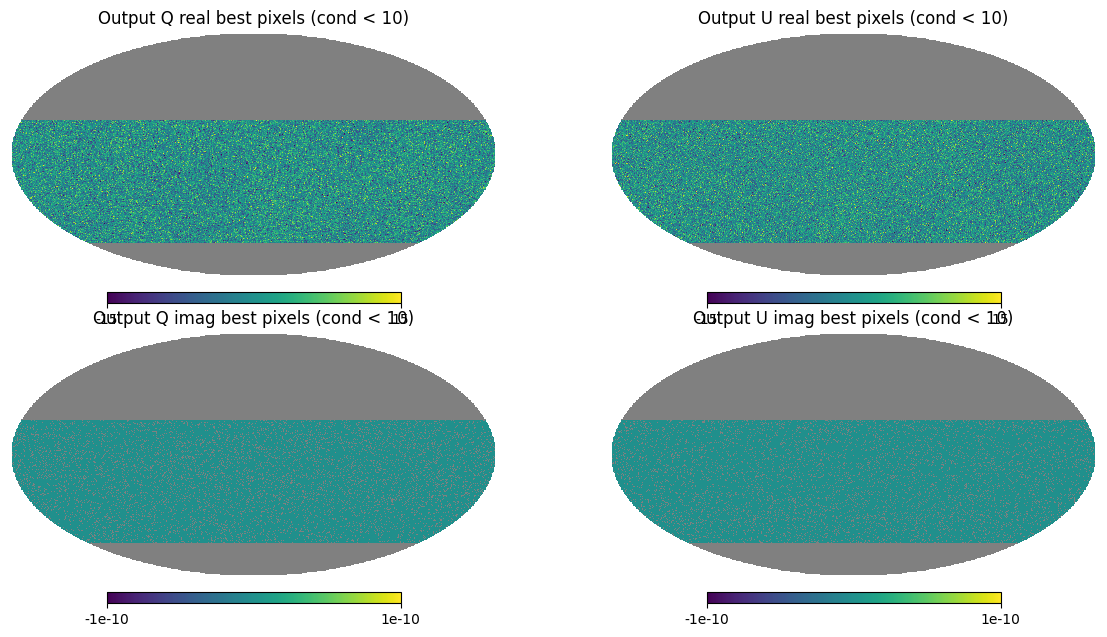

In [29]:
value = 15
plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps_best_pixels[0], sub=(2,2,1), title='Output Q real best pixels (cond < 10)', min=-value, max=value)
hp.mollview(extended_final_maps_best_pixels[1], sub=(2,2,2), title='Output U real best pixels (cond < 10)', min=-value, max=value)

value = 1e-10
# plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps_imag_best_pixels[0], sub=(2,2,3), title='Output Q imag best pixels (cond < 10)', min=-value, max=value)
hp.mollview(extended_final_maps_imag_best_pixels[1], sub=(2,2,4), title='Output U imag best pixels (cond < 10)', min=-value, max=value)
plt.show()


In [30]:
abs_best_pixels = np.abs(extended_final_maps_best_pixels[extended_final_maps_best_pixels != hp.UNSEEN])
abs_best_pixels_imag = np.abs(extended_final_maps_imag_best_pixels[extended_final_maps_imag_best_pixels != hp.UNSEEN])

print(abs_best_pixels.max(), abs_best_pixels_imag.max())
print(abs_best_pixels.min(), abs_best_pixels_imag.min())


23.143853303903974 1.9539925233402755e-14
4.701980545196438e-08 2.371692252312041e-20


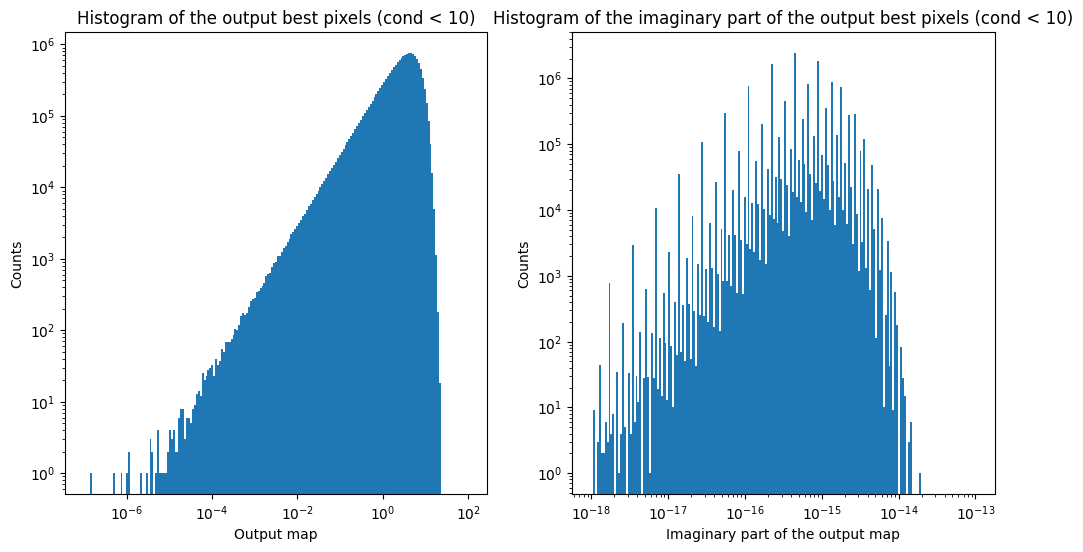

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(abs_best_pixels, bins=np.logspace(-7, 2, 200))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Output map')
plt.ylabel('Counts')
plt.title('Histogram of the output best pixels (cond < 10)')

plt.subplot(1,2,2)
plt.hist(abs_best_pixels_imag, bins=np.logspace(-18, -13, 200))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Imaginary part of the output map')
plt.ylabel('Counts')
plt.title('Histogram of the imaginary part of the output best pixels (cond < 10)')
plt.show()